In [5]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 200
%matplotlib inline

import spacy, gensim
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Import Dataset
df= pd.read_csv('/Users/vibhuverma/Desktop/CLASSWORK/BUSINESS PRACTICUM/Anti-Corruption/Data Provided/USAID_Project_Data/USAID_Anticorruption_Projects_Database.csv')
df = df.drop(['rfp_rftop','final_res','mind_eval','final_eval','audit','interim_rep','addl_docs','addl_info'],axis=1)

In [7]:
df.head(4)

,uuid,region,country,proj_nm,st_date,end_date,awd_amount,awd_value,implementer,sector,intervention,intervention_type,proj_desc,proj_res,corruption,stability
0,1,South and Central Asia (SCA),Afghanistan,Assistance for Afghanistan's Anti-Corruption Authority (4A) Project,2010,2013,e) $25 M-$50 M,26642989,Management Systems International (MSI),"Independent Agencies, Civil Society","Corruption Prevention, Public Awareness","Awareness, Accountability","The five components of this program seek to take what already exists and improve upon it, implement it and find ways to ensure that the progress achieved is sustainable over the long term. The pro...",The program developed a working relationship with the High Office of Oversight and Anti-Corruption (HOO) management and staff at all levels to enable it to realize its stated objectives; it also h...,High Corruption,Unstable
1,2,South and Central Asia (SCA),Afghanistan,Rule of Law Stabilization Program - Formal Component (RLS-Formal),2010,2012,e) $25 M-$50 M,33700000,TetraTech ARD,Rule of Law,"Court Administration, Professional Legal Education/Training, Public Information","Transparency, Awareness","The overall goal of the program was to support Rule of Law Strategy for Afghanistan, specifically Pillar 1 (improve the justice sector and reduce corruption) and Pillar 4 (build leadership in the ...",The project set up legal education training for judges and helped modernize the judicial system. The project trained and assigned judges to corruption panels and the new anticorruption tribunal on...,Very High Corruption,Very Unstable
2,3,South and Central Asia (SCA),Afghanistan,Afghanistan Rule of Law Stabilization Project (AROLP) -- informal component (RLS-I),2011,2012,c) $5 M-$10 M,10000000,"Checchi and Company Consulting, Inc.",Rule of Law,Access to Justice,"Awareness, Accountability","The project focused on strengthening and improving traditional dispute resolution mechanisms, strengthening linkages between the formal and informal justice sectors, and developing approaches to a...","The project reached 37,583 participants. In Phase 1, the project assessed the dispute and dispute resolution context, dispute types and causes, and dispute resolution actors and their relationshi...",Very High Corruption,Very Unstable
3,4,South and Central Asia (SCA),Afghanistan,Political Party Assessment,2012,2012,a) <$1 M,NaN,"Checchi and Company Consulting, Inc.",Elections and Political Processes,Assessment,Assessment,"The Political Party Assessment team aimed to reviewed materials produced by reporters, researchers, academics, and think tanks. The team interviewed over 120 individuals involved in Afghan politic...","The assessment team found that the development of political organizations, whether parties or otherwise, was constrained both by Afghan and international programmatic factors. On the Afghan side, ...",Very High Corruption,Very Unstable


In [10]:
# Convert to list
data = df.proj_desc.values.tolist()

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['The five components of this program seek to take what already exists and '
 'improve upon it, implement it and find ways to ensure that the progress '
 'achieved is sustainable over the long term. The project will help the '
 'government of the Islamic Republic of Afghanistan strengthen its High Office '
 'of Oversight (HOO) - making it a strong, effective institution that is able '
 'to lead, monitor, coordinate and report on efforts to combat corruption '
 'across the country. The project will work and implement a program of '
 'institutional development and sustainability. It will also support the '
 'office in carrying out its priority responsibilities in asset registration '
 'and verification, complaints management and case tracking, and coordination '
 'and monitoring of anticorruption performance across other government '
 'agencies.']


In [11]:
#tokenize and clean up using gensim 

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))



In [12]:
#lemmatization

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['component program seek take already exist improve implement find way ensure progress achieve sustainable long term project will help government strengthen high office oversight hoo make strong effective institution able lead monitor coordinate report effort combat corruption country project will work implement program institutional development sustainability will also support office carry priority asset registration verification complaint management case tracking coordination monitoring anticorruption performance other government agency', 'overall goal program support rule law strategy specifically pillar improve justice sector reduce corruption pillar build leadership justice sector civil society support pillar contractor attempt develop capacity judiciary law school pillar contractor work raise public awareness encourage citizen resolve dispute formal justice sector program divide component capacity building judiciary capacity building court management system capacity building facu

In [13]:
## TFIDF


vectorizer = TfidfVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             ngram_range=(1,3),             # max number of uniq words
                             use_idf=True
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [14]:
tfidf_matrix = data_vectorized.toarray()

In [15]:
# get all unique words in the corpus
vocab = vectorizer.get_feature_names()
# show document feature vectors
pd.DataFrame(tfidf_matrix, columns=vocab)

,ability,access,accountability,accountable,achieve,action,activity,actor,address,administration,...,training,transition,transparency,transparency accountability,transparent,unit,use,woman,work,year
0,0.0,0.000000,0.000000,0.0,0.154452,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.105766,0.0
1,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.074064,0.0
2,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.298353,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
3,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.315238,0.000000,0.0
4,0.0,0.000000,0.128748,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.117858,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.123287,0.0,...,0.106085,0.323104,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.093776,0.0
311,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
312,0.0,0.114961,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.121873,0.000000,0.000000,0.0
313,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0


In [16]:
###########################
### DOCUMENT SIMILARITY ###
###########################


from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(tfidf_matrix)
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df

,0,1,2,3,4,5,6,7,8,9,...,305,306,307,308,309,310,311,312,313,314
0,1.000000,0.063393,0.124795,0.118675,0.064343,0.228945,0.225706,0.075638,0.074456,0.128856,...,0.139156,0.067583,0.138826,0.075151,0.090646,0.164783,0.193209,0.023390,0.117029,0.066673
1,0.063393,1.000000,0.293407,0.012200,0.399758,0.041146,0.105717,0.010268,0.064736,0.062007,...,0.070876,0.518126,0.068418,0.237751,0.161336,0.101966,0.066812,0.012315,0.109365,0.048094
2,0.124795,0.293407,1.000000,0.130039,0.451618,0.087320,0.071358,0.023305,0.009845,0.062012,...,0.055862,0.359477,0.091813,0.035957,0.055330,0.084271,0.099567,0.024899,0.013912,0.040815
3,0.118675,0.012200,0.130039,1.000000,0.000000,0.078623,0.134240,0.103119,0.095163,0.036016,...,0.048529,0.009024,0.000000,0.000000,0.028979,0.085411,0.000000,0.023406,0.046274,0.028538
4,0.064343,0.399758,0.451618,0.000000,1.000000,0.065599,0.043841,0.045622,0.027762,0.067822,...,0.076309,0.461898,0.068112,0.240046,0.119335,0.182603,0.115111,0.016971,0.007306,0.095201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,0.164783,0.101966,0.084271,0.085411,0.182603,0.100073,0.107948,0.154081,0.109318,0.152049,...,0.116335,0.139149,0.159394,0.058474,0.218408,1.000000,0.118299,0.071207,0.130399,0.061104
311,0.193209,0.066812,0.099567,0.000000,0.115111,0.103817,0.104040,0.077941,0.071987,0.168496,...,0.122174,0.120614,0.308841,0.181505,0.150759,0.118299,1.000000,0.113957,0.103867,0.179595
312,0.023390,0.012315,0.024899,0.023406,0.016971,0.102811,0.031409,0.136943,0.088897,0.131235,...,0.130323,0.047098,0.014734,0.095465,0.202918,0.071207,0.113957,1.000000,0.031586,0.111538
313,0.117029,0.109365,0.013912,0.046274,0.007306,0.016928,0.019815,0.026064,0.041756,0.034194,...,0.063236,0.084398,0.029315,0.068112,0.022045,0.130399,0.103867,0.031586,1.000000,0.098368


Cosine similarity basically gives us a metric representing the cosine of the angle between the feature vector representations of two text documents. Lower the angle between the documents, the closer and more similar they are as depicted in the following figure.

In [18]:
### Document Clustering with Similarity Features ###

#We will be using a agglomerative clustering algorithm, which is hierarchical clustering using a bottom up approach

from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(similarity_matrix, 'ward')
pd.DataFrame(Z, columns=['Document\Cluster 1', 'Document\Cluster 2', 
                         'Distance', 'Cluster Size'], dtype='object')

<>:8: DeprecationWarning: invalid escape sequence \C
<>:8: DeprecationWarning: invalid escape sequence \C
<>:8: DeprecationWarning: invalid escape sequence \C
<>:8: DeprecationWarning: invalid escape sequence \C
<>:8: DeprecationWarning: invalid escape sequence \C
<>:8: DeprecationWarning: invalid escape sequence \C
<ipython-input-18-1ace2010fc97>:8: DeprecationWarning: invalid escape sequence \C
  pd.DataFrame(Z, columns=['Document\Cluster 1', 'Document\Cluster 2',
<ipython-input-18-1ace2010fc97>:8: DeprecationWarning: invalid escape sequence \C
  pd.DataFrame(Z, columns=['Document\Cluster 1', 'Document\Cluster 2',


,Document\Cluster 1,Document\Cluster 2,Distance,Cluster Size
0,9,11,0.599854,2
1,12,247,0.709719,2
2,69,312,0.886631,2
3,10,315,0.902329,3
4,31,118,0.927207,2
...,...,...,...,...
309,620,621,6.06046,95
310,619,624,6.75547,149
311,622,625,8.30369,215
312,623,626,9.81755,268


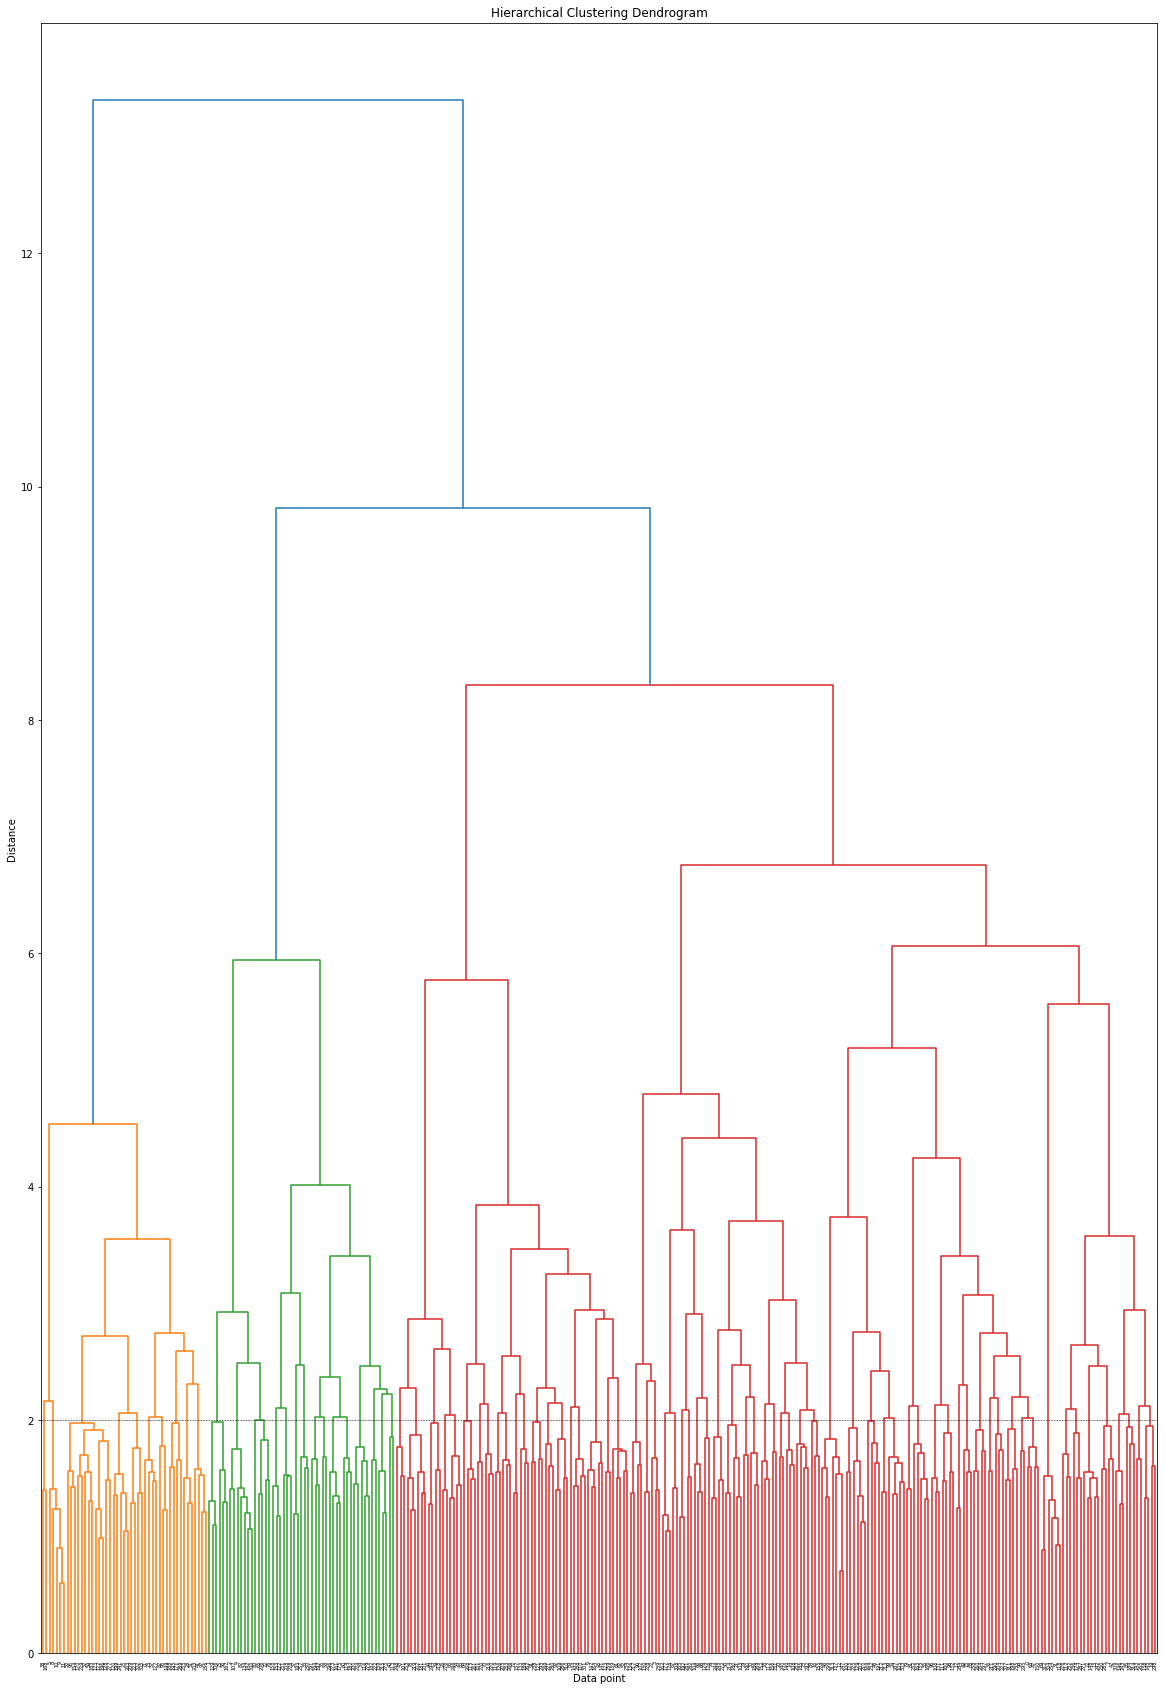

In [22]:
plt.figure(figsize=(20, 30))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data point')
plt.ylabel('Distance')
dendrogram(Z)
plt.axhline(y=2.0, c='k', ls='--', lw=0.5)

In [21]:
from scipy.cluster.hierarchy import fcluster
max_dist = 2.0

cluster_labels = fcluster(Z, max_dist, criterion='distance')
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([df, cluster_labels], axis=1)

,uuid,region,country,proj_nm,st_date,end_date,awd_amount,awd_value,implementer,sector,intervention,intervention_type,proj_desc,proj_res,corruption,stability,ClusterLabel
0,1,South and Central Asia (SCA),Afghanistan,Assistance for Afghanistan's Anti-Corruption Authority (4A) Project,2010,2013,e) $25 M-$50 M,26642989,Management Systems International (MSI),"Independent Agencies, Civil Society","Corruption Prevention, Public Awareness","Awareness, Accountability","The five components of this program seek to take what already exists and improve upon it, implement it and find ways to ensure that the progress achieved is sustainable over the long term. The pro...",The program developed a working relationship with the High Office of Oversight and Anti-Corruption (HOO) management and staff at all levels to enable it to realize its stated objectives; it also h...,High Corruption,Unstable,82
1,2,South and Central Asia (SCA),Afghanistan,Rule of Law Stabilization Program - Formal Component (RLS-Formal),2010,2012,e) $25 M-$50 M,33700000,TetraTech ARD,Rule of Law,"Court Administration, Professional Legal Education/Training, Public Information","Transparency, Awareness","The overall goal of the program was to support Rule of Law Strategy for Afghanistan, specifically Pillar 1 (improve the justice sector and reduce corruption) and Pillar 4 (build leadership in the ...",The project set up legal education training for judges and helped modernize the judicial system. The project trained and assigned judges to corruption panels and the new anticorruption tribunal on...,Very High Corruption,Very Unstable,11
2,3,South and Central Asia (SCA),Afghanistan,Afghanistan Rule of Law Stabilization Project (AROLP) -- informal component (RLS-I),2011,2012,c) $5 M-$10 M,10000000,"Checchi and Company Consulting, Inc.",Rule of Law,Access to Justice,"Awareness, Accountability","The project focused on strengthening and improving traditional dispute resolution mechanisms, strengthening linkages between the formal and informal justice sectors, and developing approaches to a...","The project reached 37,583 participants. In Phase 1, the project assessed the dispute and dispute resolution context, dispute types and causes, and dispute resolution actors and their relationshi...",Very High Corruption,Very Unstable,12
3,4,South and Central Asia (SCA),Afghanistan,Political Party Assessment,2012,2012,a) <$1 M,NaN,"Checchi and Company Consulting, Inc.",Elections and Political Processes,Assessment,Assessment,"The Political Party Assessment team aimed to reviewed materials produced by reporters, researchers, academics, and think tanks. The team interviewed over 120 individuals involved in Afghan politic...","The assessment team found that the development of political organizations, whether parties or otherwise, was constrained both by Afghan and international programmatic factors. On the Afghan side, ...",Very High Corruption,Very Unstable,49
4,30,Europe and Eurasia (E&E),Albania,Justice Sector Strengthening Project (JuST),2010,2015,c) $5 M-$10 M,9012613,Chemonics,"Rule of Law, Civil Society","Legal/Institutional Strengthening/Reform, Court Administration, Professional Legal Education/Training, Advocacy, Investigative Reporting","Transparency, Accountability, Awareness","The Justice Sector Strengthening Project (JuST) promotes court transparency, fairness, and efficiency; bolsters watchdog and anticorruption roles of civil society organizations and media, and stre...","As of September 30, 2012, the project installed digital recording equipment in 26 courtrooms in seven courts that expanded the number of hearings held in public courtrooms, and continued to suppor...",High Corruption,Unstable,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,311,Middle East and North Africa (MENA),Yemen,Responsive Governance Project (RGP),2010,2015,e) $25 M-$50 M,43000000,Counterpart International,"Civil Society, Legislature","Legislative/Institutional Strengthening/R